<h1>1- Definição de conceitos</h1> 

<h2>1.1- O que é a Baixa Pombalina para efeitos deste problema? </h2> 


A Baixa Pombalina, no âmbito deste problema, é a área delimitada onde iremos quantificar o número de cafés existentes.


A API TomTom permite georreferenciar uma zona através de vários métodos, incluindo:

<ul>
    <li>Definição de um raio: Se os parâmetros <code>radius</code> e <code>position</code> forem definidos, os resultados serão limitados à área especificada.</li>
    <li>Bounding box: Utilizando os parâmetros <code>topLeft</code> (canto superior esquerdo) e <code>btmRight</code> (canto inferior direito) para delimitar uma área retangular.</li>
    <li>Definição de um retângulo com <code>geobias</code>: Utiliza o parâmetro <code>geobias</code> para indicar uma preferência de localização num retângulo, influenciando a ordenação dos resultados, mas sem filtrar rigidamente.</li>
    <li>Definição de um polígono: Através da do serviço api <code>geometry search</code>, é possível marcar vários pontos para definir um polígono personalizado que limita os resultados à área geográfica especificada.</li>
</ul>

Ao pesquisar "Baixa Pombalina" na Wikipédia, encontrei a seguinte  representação geográfica representada na imagem abaixo. 

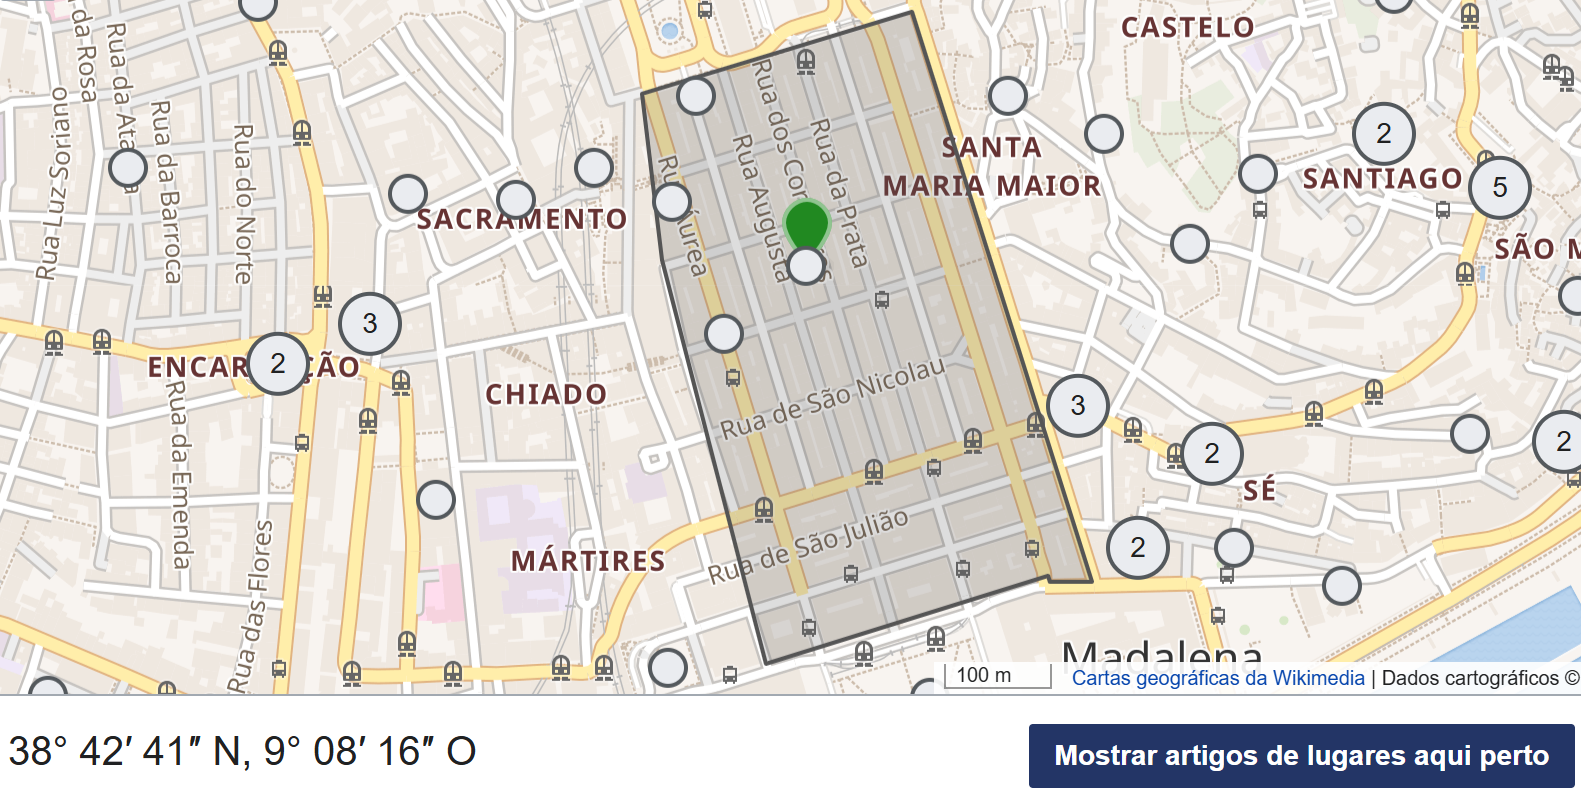


Tendo em conta que a representação acima se enquadra num polígono irregular, decidi definir a área em análise geográfica através de um polígono personalizado composto por vários vértices.

Através do site geojson.io, foram marcados vários pontos com o objetivo de definir a área do polígono representada no artigo da Wikipédia. O site permite exportar a lista de coordenadas registadas em diferentes formatos; neste caso, foi escolhido o formato CSV. O ficheiro gerado será utilizado para criar o payload do serviço GeometrySearch, no qual é passado, no seu conteúdo, um polígono com os respetivos vértices.

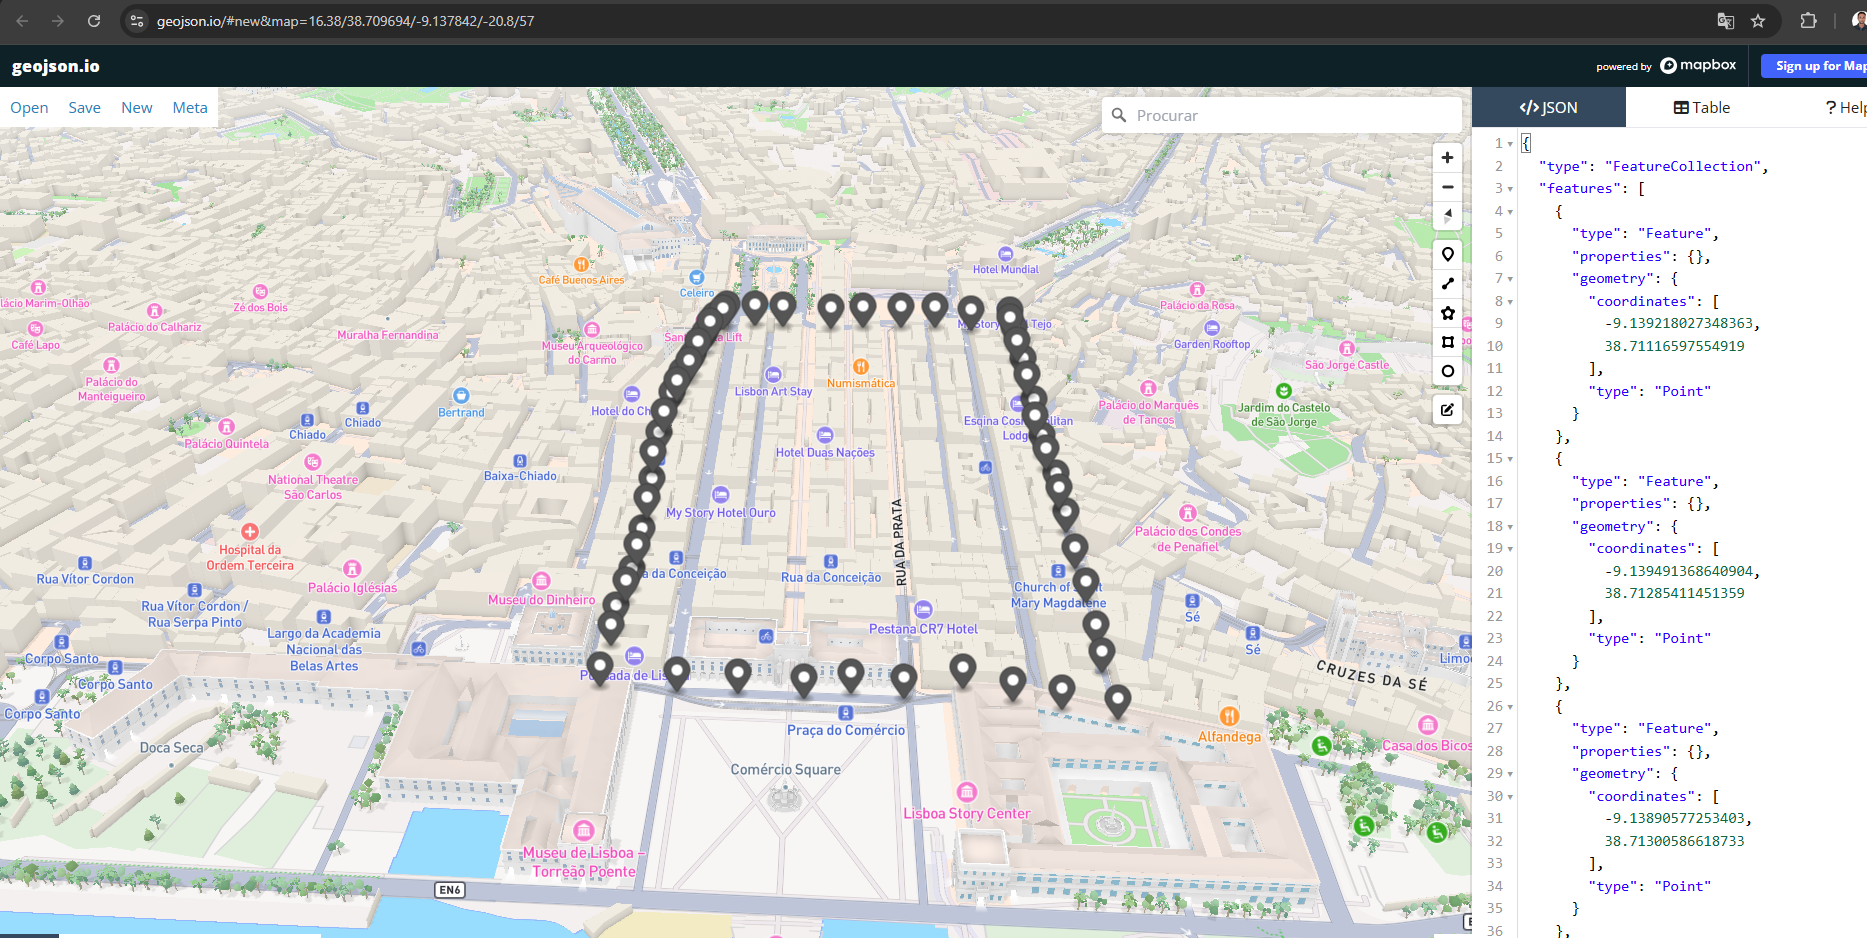


<h2>1.2- O que é uma café para efeitos deste problema?</h2> 

Para efeitos deste problema, um "café" será considerado qualquer estabelecimento comercial identificado na API TomTom como um local destinado ao consumo de café, excluindo restaurantes, que normalmente estão vocacionados para servir refeições completas. Os estabelecimentos considerados incluem:

<ul>
    <li>Cafetarias</li>
    <li>Pastelarias</li>
    <li>Espaços que ofereçam serviços de café</li>
    <li>Outros locais destinados a pequeno-almoço ou lanches</li>
</ul>


A API TomTom oferece um serviço denominado "category-search", que retorna uma lista de IDs das categorias de pontos de interesse disponíveis para pesquisa nos seus serviços. Com base neste serviço, foi definido um conjunto de palavras-chave para incluir ou excluir categorias devolvidas, caso estas contivessem essas palavras no respetivo nome ou na propriedade de sinónimos. Assim, foi criada uma lista de categorias que se enquadram como pontos de interesse do tipo "café".

<table border="1">
    <thead>
        <tr>
            <th>Palavras-Chave</th>
            <th>Palavras-Chave Exclusão</th>
        </tr>
    </thead>
    <tbody>
        <tr><td>Café</td><td>restaurant</td></tr>
        <tr><td>Coffee</td><td>wine bar</td></tr>
        <tr><td>Bakery</td></tr>
        <tr><td>Cafe</td></tr>
        <tr><td>Cafeteria</td></tr>
        <tr><td>Breakfast</td></tr>
        <tr><td>Snack</td></tr>
        <tr><td>Tea</td></tr>
        <tr><td>Pastry</td></tr>
        <tr><td>Lounge</td></tr>
        <tr><td>Doughnut</td></tr>
        <tr><td>Dessert</td></tr>
        <tr><td>Bistro</td></tr>
        <tr><td>Espresso</td></tr>
        <tr><td>Bar</td></tr>
    </tbody>
</table>


<h1>2- Implementação</h1>

<h2>Importação de Livrarias</h2>

In [73]:
import requests
import pandas as pd
import json
import csv

import folium
from IPython.display import display

<h2>Constantes</h2>

In [56]:
API_KEY = "hG3Y0C8v2Y4qEqLegXA7oF6HcpYqGKho"
MAX_CATEGORIES = 10
LIMIT_RECORDS_API = 100
KEYWORD_FILE = "data/keywords_list.csv"
PAYLOAD_POLYGON_FILE = "data/payload_polygon_vertices.txt"
CATEGORY_ID_FILE = "data/categories_id.csv"
COORDINATES_FILE = "data/input_coordinates.csv"

<h2>2.1- Obter Lista de Categorias onde se incluem os pontos de Interesse</h2>

Esta função é responsável por ler a lista de palavras-chave para incluir ou excluir categorias, definida no ficheiro CSV "keywords_list.csv", e criar listas com os respetivos conteúdos.

In [62]:
# Esta função lê lista de palavras-chave a incluir/excluir na consulta de categorias da API de Categorias TomTom
def process_keywords(input_file):
    try:
        keywords = []
        exclude_keywords = []

        # Ler o ficheiro CSV
        with open(input_file, mode='r', encoding="utf-8") as file:
            reader = csv.reader(file)
            next(reader)  # Ignorar o cabeçalho
            for row in reader:
                if len(row) >= 2:  # Certificar que existem pelo menos duas colunas
                    if len(row[0]) > 1:
                        keywords.append(row[0].strip())
                    if len(row[1]) > 1:
                        exclude_keywords.append(row[1].strip())

        return keywords, exclude_keywords
    except FileNotFoundError:
        print(f"Erro: O ficheiro '{input_file}' não foi encontrado.")
    except Exception as e:
        print(f"Ocorreu um erro ao processar o ficheiro: {e}")


input_file = KEYWORD_FILE
keywords, exclude_keywords = process_keywords(input_file)

print(keywords)
print(exclude_keywords)


['Café', 'Coffee', 'Bakery', 'Cafe', 'Cafeteria', 'Breakfast', 'Snack', 'Tea', 'Pastry', 'Lounge', 'Doughnut', 'Dessert', 'Bistro', 'Espresso', 'Bar']
['restaurant', 'barracks', 'nails', 'plateau', 'wine bar', 'Cabaret', 'Guest']


Esta função é responsável por extrair informações das categorias possíveis de pontos de interesse, utilizando a API poiCategories da TomTom. O conteúdo devolvido pela API é verificado para garantir que cumpre as regras das palavras-chave definidas no ponto anterior. O conteúdo validado é, então, guardado num ficheiro CSV.

In [64]:
# Endereço Api Categorias Possiveis de Pontos de Interesse
url = "https://api.tomtom.com/search/2/poiCategories.json"
params = {
    "key": API_KEY  
}


def fetch_and_process_category_api(url, params, keywords, exclude_keywords):
    try:
        # Chamada à API
        response = requests.get(url, params=params)

        # Verificar se request bem-sucedido
        if response.status_code == 200:
            data = response.json()  # Obter a resposta em formato JSON

            # Extrair categorias
            categories = data.get("poiCategories", [])

            # Extrair conteúdo: ids, nomes e sinônimos
            extracted_data = []
            for category in categories:
                if any(keyword.lower() in (category.get("name", "").lower() + " " + " ".join(category.get("synonyms", [])).lower()) for keyword in keywords):
                    if not any(exclude_keyword in category.get("name", "").lower() for exclude_keyword in exclude_keywords) and \
                       not any(exclude_keyword in synonym.lower() for synonym in category.get("synonyms", []) for exclude_keyword in exclude_keywords):
                        item = {
                            "id": category.get("id"),
                            "name": category.get("name"),
                            "synonyms": category.get("synonyms", [])
                        }
                        extracted_data.append(item)

            # Criar o dataframe
            df = pd.DataFrame(extracted_data)

            if not df.empty:
                print(df)

                # Guardar informação de categorias num ficheiro CSV
                df.to_csv("data/categories_id.csv", index=False)

                ids_Categorias = ",".join(map(str, df['id'].unique()))
                return ids_Categorias
            else:
                print("Nenhum dado foi extraído das categorias.")
                return None
        else:
            print(f"Erro na chamada da API: {response.status_code}")
            return None
    except requests.RequestException as re:
        print(f"Erro na requisição: {re}")
    except KeyError as ke:
        print(f"Erro ao acessar dados da resposta: {ke}")
    except ValueError as ve:
        print(f"Erro ao converter dados JSON: {ve}")
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")

# Chamada à função
ids_Categorias = fetch_and_process_category_api(url, params, keywords, exclude_keywords)
 

         id              name  \
0      9376          Café/Pub   
1   9379004               Bar   
2   7314002   B&B/Guest House   
3   7315007            Bistro   
4   7318006   Cabaret Theater   
5   9376002              Café   
6   7315147         Cafeteria   
7   9379006      Cocktail Bar   
8   9376006       Coffee Shop   
9   9379009       Comedy Club   
10  9361018            Bakery   
11  9376004     Internet Café   
12  9379008         Jazz Club   
13  9379010      Karaoke Club   
14  7315039          Pub Food   
15  7315143         Salad Bar   
16  9376005         Tea House   
17  7315149  Yogurt/Juice Bar   
18     7358        Truck Stop   
19     7375         Toll Gate   

                                             synonyms  
0                                                  []  
1                                                  []  
2   [Bed & Breakfast, B & B, B and B, Guesthouse, ...  
3                                                  []  
4                         

<h2>2.2- Extração de informação dos pontos de interesse, incluídos na lista de categorias definidas no passo anterior, respeitando área geográfica delimitada.</h2>

<h3>2.2.1- Construção do Payload da Área Poligono </h3>

Esta função é responsável por extrair os pontos de latitude e longitude incluídos no ficheiro CSV gerado pelo site geojson.io e incorporar essa informação no formato de payload, onde são definidos os vértices do polígono necessário para a solicitação de pontos de interesse na área de interesse através da API GeometrySearch

In [66]:
def csv_coordinates_to_polygon(input_file_path, output_file_path):
    # Ler as coordenadas do ficheiro CSV
    coordinates = []
    with open(input_file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        next(reader)  # Ignorar o cabeçalho (lon,lat)
        for row in reader:
            lon, lat = map(float, row)  # Convertendo para floats
            coordinates.append([lat, lon])

    # Garantir que o polígono é fechado
    if coordinates[0] != coordinates[-1]:
        coordinates.append(coordinates[0])


    # Criar o payload no formato esperado
    polygon_data = {
        "geometryList": [
            {
                "type": "POLYGON",
                "vertices": [
                    f"{lat},{lon}" for lat, lon in coordinates
                ]
            }
        ]
    }

    # Guardar o JSON resultante no ficheiro de saída
    with open(output_file_path, 'w') as output_file:
        json.dump(polygon_data, output_file, indent=2)

    print(f"Ficheiro criado: {output_file_path}")
    print(polygon_data);


# Chamada à função
csv_coordinates_to_polygon(COORDINATES_FILE,PAYLOAD_POLYGON_FILE)

Ficheiro criado: data/payload_polygon_vertices.txt
{'geometryList': [{'type': 'POLYGON', 'vertices': ['38.712876785402386,-9.139450673684593', '38.71322090469465,-9.138238992874847', '38.71350469902515,-9.13710643598273', '38.71360250457482,-9.136562297470107', '38.712884758241074,-9.13624884305753', '38.712225251325265,-9.136030236977717', '38.71154050683134,-9.135742198935134', '38.71103472083931,-9.135555184944081', '38.71050904287165,-9.135302255209439', '38.70984454842315,-9.135067879679013', '38.70921858790771,-9.134793551466885', '38.70869664192827,-9.134575963524668', '38.70868443061414,-9.135341758873125', '38.70842773036304,-9.136336120169346', '38.70824433188412,-9.137072436651152', '38.70803175311161,-9.138032455000229', '38.70882165424294,-9.138330914451132', '38.70959639657519,-9.138609347148247', '38.71033457321727,-9.138938325596769', '38.711183202506675,-9.139214553660594', '38.71171133968042,-9.139301483764541', '38.71235459899907,-9.13946467816092', '38.7128767854023

<h3>2.2.2- Obter  pontos de Interesse através da Api GeometrySearch</h3>

Esta função é responsável por ler o payload criado no passo anterior a ser enviado na Api Geometry Search

In [68]:
def load_geometry_list_from_file(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            data = json.load(file)  # Carregar o conteúdo do ficheiro como JSON
        return data.get("geometryList", [])
    except FileNotFoundError:
        print(f"Erro: O ficheiro '{file_path}' não foi encontrado.")
        return []
    except json.JSONDecodeError:
        print(f"Erro ao decodificar o ficheiro JSON: o formato pode estar incorreto.")
        return []
    except Exception as e:
        print(f"Erro ao ler o ficheiro: {e}")
        return []
    

# Carregar a lista de geometria a partir do ficheiro
geometry_list = load_geometry_list_from_file(PAYLOAD_POLYGON_FILE)

A API Geometry Search permite passar como parâmetro uma lista dos IDs das categorias de pontos de interesse para as quais pretendemos obter informação. Tendo em conta que a API tem uma limitação de apenas permitir o envio de, no máximo, 10 categorias por pedido, foi definido este valor máximo a ser respeitado em cada pedido. Caso a lista de categorias exceda o valor máximo permitido, o processo deverá subdividr o pedido à API em vários pedidos, respeitando o limite máximo de categorias por pedido. 

A função split_categories divide a lista de categorias em sublistas respeitando o limite máximo de categorias por lote.

In [69]:
def split_categories(category_set, max_categories):
    categories = category_set.split(",")
    return [categories[i:i + max_categories] for i in range(0, len(categories), max_categories)]

category_batches = split_categories(ids_Categorias, MAX_CATEGORIES)
print(category_batches)

[['9376', '9379004', '7314002', '7315007', '7318006', '9376002', '7315147', '9379006', '9376006', '9379009'], ['9361018', '9376004', '9379008', '9379010', '7315039', '7315143', '9376005', '7315149', '7358', '7375']]


A função call_geometry_search implementa uma chamada à API Geometry Search da TomTom para obter informações sobre pontos de interesse dentro da representação geográfica do polígono e incluídos na lista de categorias.

In [72]:
def call_geometry_search(api_key, category_set, geometry_list):
    try:
        # URL da API
        url = "https://api.tomtom.com/search/2/geometrySearch/.json"

        # Parâmetros Api
        params = {
            "key": api_key,
            "categorySet": category_set,
            "limit":100
      
        }

        # Corpo da requisição
        body = {
            "geometryList": geometry_list
        }

        # Realizar a chamada à API
        response = requests.post(url, params=params, json=body)

        # Verificar o status da resposta
        if response.status_code == 200:
            print("Chamada realizada com sucesso!")
            return response.json()
        else:
            print(f"Erro na chamada à API. Status code: {response.status_code}")
            print("Mensagem de erro:", response.text)
            return None

    except requests.RequestException as e:
        print(f"Erro ao realizar a requisição: {e}")
        return None
    
def parse_response_to_dataframe(response):
    data = []
    for result in response.get('results', []):
        poi = result.get('poi', {}) 
        address = result.get('address', {})
        poi_name = poi.get('name', '') 
        poi_phone = poi.get('phone', '') 
        poi_street_name = address.get('streetName', '') 
        poi_municipality_subdivision = address.get('municipalitySubdivision', '') 
        poi_postal_code = address.get('postalCode', '') 
        poi_freeform_address = address.get('freeformAddress', '')
        position = result.get('position', {})
        poi_position_lat = position.get('lat', '')
        poi_position_lon = position.get('lon', '')


        data.append({ 
            'poi_name': poi_name, 
            'poi_phone': poi_phone, 
            'poi_address.streetName': poi_street_name, 
            'poi_address.municipalitySubdivision': poi_municipality_subdivision, 
            'poi_address.postalCode': poi_postal_code, 
            'poi_freeformAddress': poi_freeform_address,
            'poi_position_lat': poi_position_lat,
            'poi_position_lon': poi_position_lon, 
            
            }) 
    df = pd.DataFrame(data) 
    return df
    
dataframes = []
for batch in category_batches:
    batch_category_set = ",".join(batch)
    result = call_geometry_search(API_KEY, batch_category_set, geometry_list)
    if result:
        df = parse_response_to_dataframe(result)
        dataframes.append(df)
        print("Resposta da API:", result)


final_df = pd.concat(dataframes, ignore_index=True) 
print(final_df)

# Guardar DataFrame log  CSV 
final_df.to_csv('resultados_pois.csv') 
#print("Dados guardados em 'resultados_pois.csv'")




Chamada realizada com sucesso!
Resposta da API: {'summary': {'query': '', 'queryType': 'NON_NEAR', 'queryTime': 191, 'numResults': 57, 'offset': 0, 'totalResults': 57, 'fuzzyLevel': 1}, 'results': [{'type': 'POI', 'id': '4IqiHUHMYhGLtImU-gnWPA', 'score': 1.0120658875, 'info': 'search:ta:620006000036077-PT', 'poi': {'name': 'Starbucks Santa Justa', 'phone': '+351 937 000 000', 'brands': [{'name': 'Starbucks'}], 'categorySet': [{'id': 9376002}], 'url': 'www.starbucks.pt', 'categories': ['café', 'café/pub'], 'classifications': [{'code': 'CAFE_PUB', 'names': [{'nameLocale': 'en-US', 'name': 'café'}, {'nameLocale': 'en-US', 'name': 'café/pub'}]}]}, 'address': {'streetNumber': '79', 'streetName': 'Rua de Santa Justa', 'municipalitySubdivision': 'Santa Maria Maior', 'municipality': 'Lisboa', 'countrySecondarySubdivision': 'Lisboa', 'countrySubdivision': 'Portugal Continental', 'postalCode': '1100', 'extendedPostalCode': '1100-125', 'countryCode': 'PT', 'country': 'Portugal', 'countryCodeISO3'

Representar geograficamente os pontos de interesse identificados e verificar a sua posição em relação aos limites geográficos definidos na análise. Os pontos de interesse são assinalados a azul e os limites geográficos a vermelho.

In [ ]:
# Centrar o mapa num ponto através do calculo da média das latitudes/longitudes dos pontos de interesses encontrados.
map = folium.Map(location=[final_df["poi_position_lat"].mean(), final_df["poi_position_lon"].mean()], zoom_start=14)

# Marcar no mapa os pontos de interesse
for _, row in final_df.iterrows():
    folium.Marker(
        location=[row["poi_position_lat"], row["poi_position_lon"]],
        popup=row["poi_name"],
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map)

# Marcar no mapa  limite geográfico da análise.
df_polygon_vertex = pd.read_csv(COORDINATES_FILE)
folium.PolyLine(
    locations=df_polygon_vertex[["lat", "lon"]].values.tolist(),
    color='red',  # Cor da linha
    weight=5,  # Espessura da linha
    opacity=0.8  # Transparência
).add_to(map)

display(map)

         lon        lat
0  -9.139451  38.712877
1  -9.138239  38.713221
2  -9.137106  38.713505
3  -9.136562  38.713603
4  -9.136249  38.712885
5  -9.136030  38.712225
6  -9.135742  38.711541
7  -9.135555  38.711035
8  -9.135302  38.710509
9  -9.135068  38.709845
10 -9.134794  38.709219
11 -9.134576  38.708697
12 -9.135342  38.708684
13 -9.136336  38.708428
14 -9.137072  38.708244
15 -9.138032  38.708032
16 -9.138331  38.708822
17 -9.138609  38.709596
18 -9.138938  38.710335
19 -9.139215  38.711183
20 -9.139301  38.711711
21 -9.139465  38.712355
[[-9.139450673684593, 38.71287678540239], [-9.138238992874848, 38.71322090469465], [-9.13710643598273, 38.71350469902515], [-9.136562297470109, 38.71360250457482], [-9.13624884305753, 38.712884758241074], [-9.136030236977716, 38.71222525132527], [-9.135742198935134, 38.71154050683134], [-9.13555518494408, 38.71103472083931], [-9.13530225520944, 38.71050904287165], [-9.135067879679012, 38.70984454842315], [-9.134793551466885, 38.70921858790771],